# Optical Spectroscopy Lab 6
###### By Jack Schapira

## Abstract

We present a python script that takes a spectrum obtained by the Angell Hall Telescope CCD, and calibrates it to fit real observed spectral lines. We will take two spectrums: that of a neon light, and that of the sky. The absorption lines of the Neon light are already known, and hence can be used to calibrate the spectrums we obtain. We then compare the solar spectrum to known absoprtion lines of the Sun, and compare- to see the types of lines as well as there abundance in absorption in the line of sight.

## Introduction

Spectroscopy identifies absorption/emission lines of incident sources. This type of information is essential to the study of the source, as it provides information relating the wavelength of the light to that of the characteristic element(s) that cause the emission/absorption line. This is very useful for Astronomers, allowing them to determine the chemical composition of cosmic sources.

Spectroscopy can also be used to determine the doppler shift of an object, by observing the movement of the spectrum's wavelengths. This allows astronomers to determine other physical quantities about the source, for example it's radial velocity.

## Theory

For this experiment, a diffraction grating containing slits is set up in front of the CCD, that splits up incident light into according to the wavelength of the light. The light then diverges from the slit, which is captured by the CCD. The different wavelengths diverge at different positions on the CCD, hence we obtain in image of a spectrum of light.

We start by taking calibration frames from a Neon light source, whilst deducting the ambient 'background' light within the dome itself. The image obtained will be an emission spectrum of the Neon light. The emission lines are characterised by the energy gaps between excitation states of Neon. Upon de-excitation of an electron in neon, a photon of light is emitted with a wavelength related to the difference between energy levels ($E=\frac{hc}{\lambda}$ where h is Plancks Constant and c is the speed of light). Using a list of known wavelengths of neon emission we can make a linear calibration of the pixel location of an emission line to the wavelength of light it represents. In this experiment we will only consider a linear transformation, however it is worth noting that in practice this is not the only transformation that should be considered; dispersion of light across a CCD is not linear for example. But in this experiment we will consider it as linear. This experiment also only reduces the dark current data from the sky images. Flat field data has not been taken in this experiment, but it is worth noting that since it has not been taken this also reduces the accuracy of the experiment.

The linear calibration makes use of the fact that we know an approximation of 4.3 angstroms/pixel. There is of course an offset as well, as visible light is in the 400-700nm regime of the EM spectrum, that will be found by trial and error in the experiment below.

We can then use this linear calibration for the solar spectrum. The solar spectrum is obtained by pointing the telescope at a cloudy region of the sky. (We do not point towards the Sun as this will be too bright, and the weather does not permit for it either- a cloudy background provides a white and uniform frame.)

Finally, we can compare the absorptions in the solar spectrum to that of actual science data. This will tell us important information about the composition of the Sun- what elements are present as well as their abundances.

## Experiment and Methodology

We begin by importing necessary tools and packages, and defining a function for plotting a graph and image.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib import rc
from IPython.display import Image
from scipy.optimize import curve_fit 
from glob import glob
rc('figure', figsize = (10.0, 10.0))
%matplotlib inline

In [2]:
def plot(xdata,ydata,xlim1,xlim2,xlab,ylab,title,color):
    plt.figure(figsize=(8,6))
    plt.plot(xdata,ydata,color=color)
    plt.xlim(xlim1,xlim2)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True)

def imshow(image,title):
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.xlabel('Pixel Number')
    plt.ylabel('Pixel Number')
    plt.title(title)
    plt.show()

Get some dimensions of the image to work with. Then import bias, dark, and sky frames whilst finding their respective average frames and substracting dark from the sky frames.

In [3]:
image = fits.getdata('Bias00000001.fit').astype(int)
height, width = image.shape

biasset = []
biassum = np.zeros((height,width))
for file in glob('Bias*'):
    biasdata = fits.getdata(file).astype(int)
    biasset.append(biasdata)
    biassum = biassum + biasdata
biasavg = biassum/len(biasset)

darkset = []
darksum = np.zeros((height,width))
for file in glob('Dark*'):
    darkdata = fits.getdata(file).astype(int)
    darkset.append(darkdata)
    darksum = darksum + darkdata
darkavg = darksum/len(darkset)

skyset = []
skysum = np.zeros((height,width))
for file in glob('skySGSNoTarget*'):
    skydata = fits.getdata(file).astype(int) - darkavg
    skyset.append(skydata)
    skysum = skysum + skydata
skyavg = skysum/len(skyset)
sky = skyavg[5:140,::-1]

imshow(sky,'Uncalibrated Solar Spectrum')

Import all neon and background frames, averaging and subtracting background from source.

In [4]:
neonbkgdset = []
neonbkgdsum = np.zeros((height,width))
for file in glob('neonbackgroundSGSNoTarget*'):
    neonbkgddata = fits.getdata(file).astype(int)
    neonbkgdset.append(neonbkgddata)
    neonbkgdsum = neonbkgdsum + neonbkgddata
neonbkgdavg = neonbkgdsum/len(neonbkgdset)

neonset = []
neonsum = np.zeros((height,width))
for file in glob('neonSGSNoTarget*'):
    neondata = fits.getdata(file).astype(int) - neonbkgdavg
    neonset.append(neondata)
    neonsum = neonsum + neondata
neonavg = neonsum/len(neonset)

neon = neonavg[5:140,::-1]
height2,width2 = neon.shape
imshow(neon,'Uncalibrated Neon Spectrum')

Evidently the lines are not straight. Therefore, to improve the accuracy of the results, and to not waste data, we will now apply a transformation to align the lines to be approximately within the same pixel number. The method to do so involves finding the maximum count value in each row of the image. Finding this location for each row and putting this into its own array, and then subtracting an offset, provides an array containting the offset of each row respectively.

In [5]:
maxvals = []
offset = []
for i in range(height2): # height2=135
    arr = neon[i,:]
    maxvals.append(np.argmax(arr))
    offset.append(np.argmax(arr)-301)
print('Pixel Locations of Maximum Counts:',maxvals)
print('Offset array:',offset)

Pixel Locations of Maximum Counts: [301, 301, 302, 302, 302, 302, 302, 302, 302, 302, 302, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 304, 304, 304, 304, 304, 305, 305, 305, 305, 305, 305, 305, 305, 305, 305, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 306, 307, 307, 307, 307, 307, 307, 307, 307, 307, 307, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 309, 309, 309, 309, 309, 309, 309, 309, 309, 309, 310, 310, 310, 310, 310, 310, 310, 310, 310, 310, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 311, 312, 312, 312, 312, 312, 312, 312, 312, 312, 313, 313, 313, 313, 313, 313, 313, 313, 313, 313, 314, 314, 314, 314, 314, 314, 314, 314, 314, 314]
Offset array: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9

Using these offset values we can move each row respecitvely according to the amount of offset needed. To do so requires a for loop, looping over each row and moving the pixels accordingly using the 'roll' function by numpy. We proceed with both the neon and solar spectrum, as the offset will be the same in both images (both taken with the same CCD).

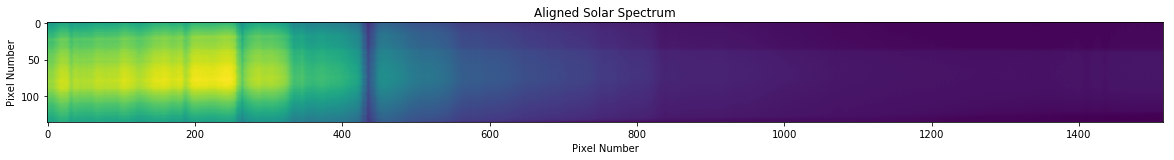

In [6]:
neoncorr = np.zeros((height2,width2))
skycorr = np.zeros((height2,width2))
for i in range(height2):
    neoncorr[i,:] = np.roll(neon[i,:],-offset[i])
    skycorr[i,:] = np.roll(sky[i,:],-offset[i])

skycor = skycorr[:,0:1515]
neoncor = neoncorr[:,0:1515]
imshow(neoncor,'Aligned Neon Spectrum')
imshow(skycor,'Aligned Solar Spectrum')

Now the spectrums are aligned we can collapse the images so that we use all the available data. Each column is summed so that two flat arrays are obtained for the neon and solar spectrums that contain the total number of counts from the line at that point. These arrays can be plotted, with pixel location on the x axis against the intensity counts on the y axis.

In [7]:
skycollapsed = np.zeros(1515)
neoncollapsed = np.zeros(1515)
for i in range(1515):
    skycollapsed[i] = np.sum(skycor[:,i])
    neoncollapsed[i] = np.sum(neoncor[:,i])

plot(np.arange(1515), np.log(skycollapsed),0,1515,'Pixel Location','Log(Counts)','Uncalibrated Sky Spectrum','b')
plt.show()
plot(np.arange(1515), np.log(neoncollapsed),0,1515,'Pixel Location','Log(Counts)','Uncalibrated Neon Spectrum','b')
plt.show()

Note the difference between the solar and neon spectrums. The solar spectrum shows drops in intensity corresponding to absorption lines of elements that absorb radiation at these wavelengths. However, the neon peaks in intensity are rather due to emission by the neon gas (due to the de-exicatation of electrons).

Now we can attempt to match the peaks obtained above in the Neon spectrum to that of real science information, provided in the 'neon_jdm.txt' file.

In [8]:
neonlines = np.loadtxt('neon_jdm.txt',usecols=(0))
plt.figure(figsize=(8,6))
for line in (neonlines):
    plt.axvline(line,color='g')
plt.xlim(6000,7600)
plt.xlabel('Wavelength (A)')
plt.title('Neon Emission Lines')
plt.grid(b=None)
plt.show()

Note that the strongest peak around 7050 angstroms matches well with the sharpest peak in our data, that has a pixel location of around 300 pixels. We can then assume that the second strongest peak at roughly 375 pixels (two peaks to the right of the one at 300 pixels) will take the wavelength value of the peak at roughly 7250 angstroms. Hence,

$ 7050 = 300m+C $

$ 7250 = 375m+C $

Now we can solve these simultaneously to give approximate values of m and C.

Through trial and error the values of m and C are obtained below, which when plotted over the known neon lines can be seen to fit the data nicely.

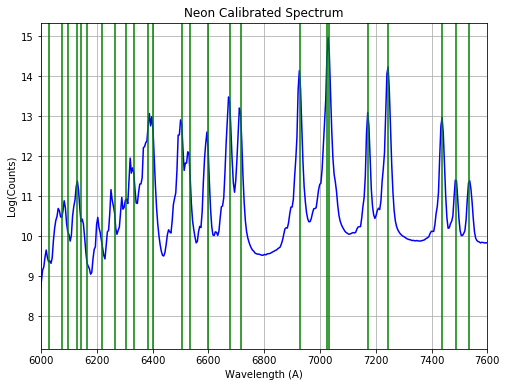

In [10]:
numberofcols = len(neoncollapsed)
colnum = np.arange(numberofcols)
m = 4.3
C = 5735
wavelength = m*colnum + C

plot(wavelength, np.log(neoncollapsed),6000,7600,'Wavelength (A)','Log(Counts)','Neon Calibrated Spectrum','b')
for line in (neonlines):
    plt.axvline(line,color='g')
plt.show()

The same linear transformation can be applied to the Solar Spectrum. Characteristic absorption lines from the Sun are given by Appendix [1], and listed in the array below (in nm). These can be overplotted over our now calibrated solar spectrum, so that we can compare the lines observed to the lines known.

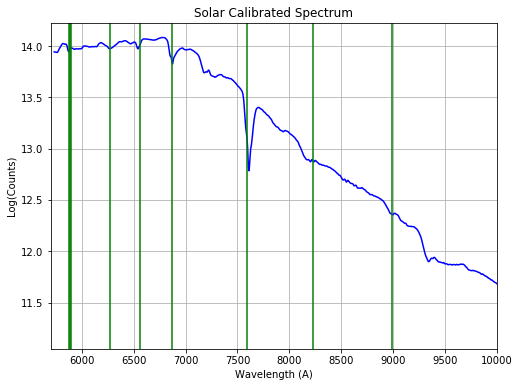

In [11]:
sunlines = [898.765,495.761,822.696,486.134,759.37,466.814,686.719,
            438.355,656.281,434.047,627.661,430.79,589.592,430.774,
            588.995,410.175,587.5618,396.847,546.073,393.366,527.039,
            382.044,518.362,358.121,517.27,336.112,516.891,302.108,516.733,299.444]
sunlines2 = np.zeros(30)
for i in range(30):
    sunlines2[i] = sunlines[i]*10

plot(wavelength,np.log(skycollapsed),5700,10000,'Wavelength (A)','Log(Counts)','Solar Calibrated Spectrum','b')
for line in (sunlines2):
    plt.axvline(line, color='g')
plt.show()

We can identify a few lines from this graph, such as:

$ 7593.70 $ angstroms = $ O_2 $ (strongest line in our spectrum)

$ 6867.19 $ angstroms = $ O_2 $

$ 6562.81 $ angstroms = $ H\alpha $

## Summary

We started by obtaining average sky and neon spectrums that included subtraction of the dark/background frames. The lines appeared to be slanted, therefore this was corrected for so that the lines appeared straight in the image, and could be collapsed to not waste important data.

These arrays then underwent linear transformations so that pixel number became an actual wavelength of light. This was done using the neon calibration frame- identifying some peaks in our data and comparing them to known neon lines. We used the same transformation for the solar spectrum (as the CCD and gratings used were the same in both spectrums). With a calibrated solar spectrum we compared and overplotted with known solar absorption lines.

## Conclusion

The results of this lab allow us to conclude that the radiation incident on a telescope from the cloudy white sky does not serve as a very good indication of the solar element abundance. The results do show Hydrogen alpha lines, however the absorption lines due to this are clearly not nearly as great as the lines from the oxygen, that must be coming from the atmosphere.

The lab also shows the importance of taking the necessary steps to obtain an accurate spectrum. In this lab only 'background' frames were taken (i.e. the intrinsic light within the dome). To improve on accuracy flat fields could be taken in order to remove vignetting effects, for example. However, this method was just used to calibrate the spectrum, in which it did a very good job. The results clearly allowed us to make observations on the absorption lines within the sky spectrum.

Appendix [1] https://en.wikipedia.org/wiki/Fraunhofer_lines